In [1]:
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
import torch
import math

from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,attn2map
from ithor_tools.map import single_scenemap
from grad_cam.cam import clip_grad_cam
from FBE.fbe import gridmap
from ai2thor.util.metrics import get_shortest_path_to_object
from ithor_tools.utils import check_vis,step_local_search
# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing
from FBE.step import step_frontier

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_gradcam = clip_grad_cam(device)

/home/kkiruk/.pyenv/versions/3.8.8/envs/ai2thor/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
gridSize=0.05
scene_name = "FloorPlan_Train1_2"
controller = Controller(
    agentMode="locobot",
    visibilityDistance=2.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    width=300,
    height=300,
    fieldOfView=90
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)



INFO - 2022-06-04 18:43:38,085 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


<ai2thor.server.Event at 0x7f9aa3f26850
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [4]:
objects = controller.last_event.metadata['objects']
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Book,Book|+09.60|+00.89|-02.55,Book_8,9.5970,0.8882,-2.5540,0.0541,173.2672,0.9073,7.8570,...,0.0,True,False,False,0.50,[Paper],Book_8,[SideTable|+09.56|+00.00|-01.95],None,False
1,Book,Book|+09.60|+00.91|-02.55,Book_7,9.5972,0.9084,-2.5540,359.9215,177.7804,1.4336,7.8572,...,0.0,True,False,False,0.50,[Paper],Book_7,[SideTable|+09.56|+00.00|-01.95],None,False
2,Bottle,Bottle|+01.14|+00.45|-02.70,Bottle_1,1.1360,0.4510,-2.7040,359.9465,0.0120,359.9853,0.8000,...,0.0,True,False,False,0.20,[Glass],Bottle_1,"[SideTable|+01.31|+00.00|-02.82, Floor|+00.00|...",None,False
3,DeskLamp,DeskLamp|+07.62|+00.48|-04.34,Desk_Lamp_7,7.6241,0.4812,-4.3350,359.9747,0.0313,0.0723,6.0498,...,0.0,False,False,True,2.06,"[Metal, Fabric]",Desk_Lamp_7,"[CoffeeTable|+07.63|+00.00|-04.34, Floor|+00.0...",[],True
4,BasketBall,BasketBall|+09.54|+00.23|-02.66,Basketball_1,9.5365,0.2302,-2.6617,0.0350,331.8078,310.5380,7.8206,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,"[Floor|+00.00|+00.00|+00.00, Shelf|+09.54|+00....",None,True
5,Laptop,Laptop|+05.64|+00.74|-04.23,Laptop_12,5.6371,0.7416,-4.2301,0.0223,269.9972,-0.0010,4.0955,...,1.0,True,False,False,2.30,"[Metal, Plastic, Glass]",Laptop_12,[Desk|+05.57|00.00|-04.29],[],True
6,SprayBottle,SprayBottle|+01.48|+00.10|-02.77,Spray_Bottle_8,1.4750,0.1014,-2.7650,0.0238,150.1202,0.0539,0.8655,...,0.0,True,False,False,0.11,[Plastic],Spray_Bottle_8,"[Shelf|+01.31|+00.10|-02.83, Floor|+00.00|+00....",None,True
7,GarbageCan,GarbageCan|+01.26|-00.03|-03.24,bin_12,1.2570,-0.0294,-3.2450,-0.0002,-0.0004,-0.0002,1.0935,...,0.0,False,False,True,0.70,[Metal],bin_12,[Floor|+00.00|+00.00|+00.00],None,False
8,RemoteControl,RemoteControl|+01.63|+00.74|-01.27,Remote_3,1.6251,0.7410,-1.2680,-0.0017,276.9755,0.0015,1.6942,...,0.0,True,False,False,0.15,"[Metal, Plastic]",Remote_3,[DiningTable|+01.46|00.00|-01.73],None,True
9,Bowl,Bowl|+01.19|+00.45|-02.93,Bowl_12,1.1860,0.4516,-2.9310,359.8806,-0.0016,359.8692,0.7214,...,0.0,True,False,False,0.47,[Ceramic],Bowl_12,"[SideTable|+01.31|+00.00|-02.82, Floor|+00.00|...",None,True


In [5]:
query_object_index = 16
query_object = objects[query_object_index]
pos = controller.last_event.metadata['agent']['position']
try:
    min_path = get_shortest_path_to_object(controller,query_object['objectId'],pos)
    min_length = 0
    last_pos = pos
    for p in min_path:
        min_length += math.sqrt((last_pos['x']-p['x'])**2+(last_pos['z']-p['z'])**2)
        last_pos = p
except:
    min_length = 0.1

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
(98, 59)
(418, 713, 3)


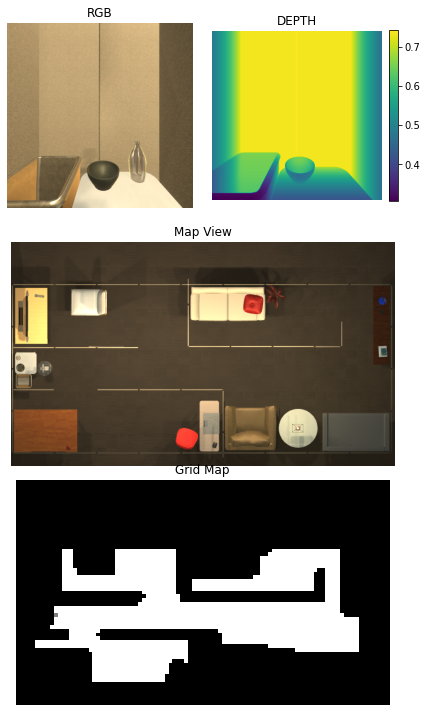

In [6]:
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)

scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [7]:
proj = attn2map(controller,sm.gridmap)
fbe = gridmap(controller,scene_bounds,clip_gradcam,proj,sm)
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789


In [ ]:
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
        )

pos = controller.last_event.metadata['agent']['position']
try:
    min_path = get_shortest_path_to_object(controller,query_object['objectId'],pos)
    min_length = 0
    last_pos = pos
    for p in min_path:
        min_length += math.sqrt((last_pos['x']-p['x'])**2+(last_pos['z']-p['z'])**2)
        last_pos = p
except:
    min_length = 0.1

In [ ]:
query_object_name = query_object['objectType']

new_query_object_name = ''
if len(query_object_name)>2:
    for i, letter in enumerate(query_object_name):
        if i and letter.isupper():
            new_query_object_name += ' '
        new_query_object_name += letter.lower()
else:
    new_query_object_name = query_object_name
clip_gradcam.set_text(new_query_object_name)
print(new_query_object_name)

In [ ]:
gt_find = False
total_path_len = 0
while gt_find != True:
    gt_find,sucess,path_len, reset_map  = step_frontier(fbe,rrtplanner,controller,query_object,clip_gradcam=clip_gradcam,vis=True,verbose=True)
    total_path_len += path_len
    if reset_map:
        proj.reset()
        fbe.reset()
SPL = sucess*min_length/total_path_len
print(SPL)